# Aurora Forecasting - Part 04: Actionable Batch Inference

🗒️ This notebook is divided into the following sections:
Load the trained Kp prediction model from the Hopsworks Model Registry.

Retrieve the most recent solar wind features.

Predict the current Kp index.

Retrieve the latest cloud cover for Stockholm, Luleå, and Kiruna.

Apply city-specific logic to determine if an Aurora is truly visible.

In [32]:
import hopsworks
import joblib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from config import HopsworksSettings
import util
import os

settings = HopsworksSettings()
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()
mr = project.get_model_registry()

HopsworksSettings initialized!
2026-01-11 03:36:10,596 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-11 03:36:10,600 INFO: Initializing external client
2026-01-11 03:36:10,600 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-11 03:36:11,239 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-11 03:36:11,980 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Step 1: Load the Registered Model

We retrieve the latest version of our Random Forest model from the registry to make our geomagnetic predictions.

In [ ]:
# 2. Download and Load Models (3h and 6h versions)
print("Downloading models from Registry...")

# Load 3-Hour Model
model_3h_obj = mr.get_model(name=settings.MODEL_3H_NAME, version=settings.MODEL_3H_VERSION)
model_3h_dir = model_3h_obj.download()
model_3h = joblib.load(os.path.join(model_3h_dir, "model_3h.pkl"))
print(f"Loaded {settings.MODEL_3H_NAME} v{model_3h_obj.version}")

Downloading: 0.000%|          | 0/2323147 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/2338408 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_3h_model version 1 ONE


In [ ]:
# Load 6-Hour Model
model_6h_obj = mr.get_model(name=settings.MODEL_6H_NAME, version=settings.MODEL_6H_VERSION)
model_6h_dir = model_6h_obj.download()
model_6h = joblib.load(os.path.join(model_6h_dir, "model_6h.pkl"))
print(f"Loaded {settings.MODEL_6H_NAME} v{model_6h_obj.version}")

Downloading: 0.000%|          | 0/2323147 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/2338408 elapsed<00:00 remaining<?

Successfully loaded aurora_kp_6h_model version 1 ONE


# Step 2: Retrieve Latest Features and Predict Kp

We fetch the most recent minute-by-minute data from NOAA. In a production environment, you would typically pull the latest data from the Online Feature Store.

In [ ]:
print("Fetching fresh data from Feature Store...")

# Fetch Raw Solar Wind Data (for the dashboard history)
solar_wind_fg = fs.get_feature_group(name="solar_wind_fg", version=8)
solar_wind_df = solar_wind_fg.read()
solar_wind_df['date_and_time'] = pd.to_datetime(solar_wind_df['date_and_time'])
solar_wind_df = solar_wind_df.sort_values(by='date_and_time').reset_index(drop=True)
last_raw_date = solar_wind_df['date_and_time'].iloc[-1]
print(f"Raw data fetched: {len(solar_wind_df)} rows. Most recent: {last_raw_date}")

Fetching fresh data from Feature Store...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.87s) 
Raw data fetched: 85942 rows. Most recent: 2026-01-11 01:00:00+00:00


,date_and_time,by_gsm,bz_gsm,density,speed,dynamic_pressure
0,2016-01-14 01:00:00+00:00,-1.90,1.70,2.700000,510.000000,7.022700e+05
1,2016-01-14 02:00:00+00:00,-2.20,-2.80,2.700000,532.000000,7.641648e+05
2,2016-01-14 03:00:00+00:00,-1.60,-1.50,2.600000,514.000000,6.869096e+05
3,2016-01-14 04:00:00+00:00,-1.00,1.50,2.800000,525.000000,7.717500e+05
4,2016-01-14 05:00:00+00:00,-1.20,0.30,2.400000,490.000000,5.762400e+05
...,...,...,...,...,...,...
85937,2026-01-10 21:00:00+00:00,-9.76,-14.12,17.580000,577.799988,5.869133e+06
85938,2026-01-10 22:00:00+00:00,-13.36,-9.56,22.040001,556.900024,6.835433e+06
85939,2026-01-10 23:00:00+00:00,-0.41,-5.64,0.400000,540.799988,1.169859e+05
85940,2026-01-11 00:00:00+00:00,-6.68,8.87,13.760000,521.200012,3.737896e+06


In [ ]:
# Fetch Aggregated Data (for the model input)
solar_wind_aggregated_fg = fs.get_feature_group(name="solar_wind_aggregated_fg", version=3)
solar_wind_aggregated = solar_wind_aggregated_fg.read()
solar_wind_aggregated['window_start'] = pd.to_datetime(solar_wind_aggregated['window_start'])
solar_wind_aggregated['window_end'] = pd.to_datetime(solar_wind_aggregated['window_end'])
solar_wind_aggregated = solar_wind_aggregated.sort_values(by='window_start').reset_index(drop=True)
last_agg_date = solar_wind_aggregated['window_end'].iloc[-1]
print(f"Aggregated data fetched: {len(solar_wind_aggregated)} rows. Most recent: {last_agg_date}")

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 
Aggregated data fetched: 28660 rows. Most recent: 2026-01-10 21:00:00+00:00


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_std,speed_mean,speed_min,speed_max,speed_std,dynamic_pressure_mean,dynamic_pressure_min,dynamic_pressure_max,dynamic_pressure_std,kp_index
0,2016-01-14 00:00:00+00:00,2016-01-14 03:00:00+00:00,-2.050000,-2.20,-1.90,0.212132,-0.550000,-2.80,1.70,3.181981,...,0.000000,521.000000,510.000000,532.000000,15.556349,7.332174e+05,7.022700e+05,7.641648e+05,4.376624e+04,1.30
1,2016-01-14 03:00:00+00:00,2016-01-14 06:00:00+00:00,-1.266667,-1.60,-1.00,0.305505,0.100000,-1.50,1.50,1.509967,...,0.200000,509.666656,490.000000,525.000000,17.897858,6.782998e+05,5.762400e+05,7.717500e+05,9.803895e+04,2.00
2,2016-01-14 06:00:00+00:00,2016-01-14 09:00:00+00:00,-3.066667,-4.00,-1.90,1.069268,-1.433333,-3.10,1.00,2.154840,...,0.115470,514.000000,501.000000,535.000000,18.357559,7.045628e+05,6.526026e+05,7.441850e+05,4.702133e+04,2.30
3,2016-01-14 09:00:00+00:00,2016-01-14 12:00:00+00:00,-0.900000,-3.20,1.30,2.251666,0.700000,-1.10,2.20,1.670329,...,0.100000,502.333344,493.000000,507.000000,8.082904,7.062038e+05,6.940323e+05,7.197372e+05,1.290643e+04,2.00
4,2016-01-14 12:00:00+00:00,2016-01-14 15:00:00+00:00,-1.500000,-2.40,-0.70,0.854400,-0.500000,-1.90,0.90,1.400000,...,0.251661,468.000000,454.000000,480.000000,13.114877,5.645089e+05,4.740668e+05,6.451200e+05,8.594934e+04,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28655,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,...,1.517926,485.133331,475.100006,497.700012,11.511009,9.540338e+05,5.333473e+05,1.238526e+06,3.717943e+05,3.67
28656,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,...,0.829538,483.799988,464.100006,505.600006,20.829546,9.257776e+05,6.957059e+05,1.234700e+06,2.780136e+05,2.67
28657,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,...,1.509845,482.466675,478.899994,486.299988,3.707200,1.230068e+06,8.231096e+05,1.452034e+06,3.529208e+05,4.33
28658,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.450000,-7.57,1.18,4.397238,-5.283333,-6.57,-3.31,1.735089,...,0.721965,472.233337,465.100006,483.000000,9.487009,1.730536e+06,1.649090e+06,1.858172e+06,1.119324e+05,3.33


In [ ]:
# 4. Check if we need to aggregate new raw data
print(f"\nComparing timestamps:\nRaw: {last_raw_date}\nAggregated: {last_agg_date}")

if pd.Timestamp(last_raw_date) > pd.Timestamp(last_agg_date):
    print("✅ Raw data is newer. Checking for aggregatable windows...")
    
    # Filter strictly new data
    new_data_df = solar_wind_df[solar_wind_df['date_and_time'] >= pd.Timestamp(last_agg_date)].copy()
    
    # We need at least 2 data points to aggregate a window meaningfully
    if len(new_data_df) >= 2:
        print(f"Aggregating {len(new_data_df)} new rows...")
        
        # Add placeholder kp for aggregation function (inference mode)
        new_data_df['kp_index'] = 99.0 
        
        new_aggregated_df = util.aggregate_solar_wind_3h(new_data_df, min_samples=2)
        
        if not new_aggregated_df.empty:
            # Drop the placeholder before merging
            new_aggregated_df = new_aggregated_df.drop(columns=['kp_index'], errors='ignore')
            
            # Merge
            solar_wind_aggregated = pd.concat([solar_wind_aggregated, new_aggregated_df], ignore_index=True)
            solar_wind_aggregated = solar_wind_aggregated.sort_values(by='window_start').reset_index(drop=True)
            print(f"New total aggregated rows: {len(solar_wind_aggregated)}")
        else:
             print("New data insufficient to form a complete 3h window.")
    else:
        print("Not enough new data to aggregate yet.")
else:
    print("⚠️ Aggregated data is already up to date.")

# Keep only recent history to keep processing fast
solar_wind_aggregated = solar_wind_aggregated.tail(100).reset_index(drop=True)

Last raw data timestamp: 2026-01-11 01:00:00+00:00
Last aggregated data timestamp: 2026-01-10 21:00:00+00:00

✅ Raw data 2026-01-11 01:00:00+00:00 is more recent than aggregated data 2026-01-10 21:00:00+00:00. Will aggregate new data...
Found 5 new rows to potentially aggregate
There are the potential new data to aggregate:
                   date_and_time  by_gsm  bz_gsm    density       speed  \
85937 2026-01-10 21:00:00+00:00   -9.76  -14.12  17.580000  577.799988   
85938 2026-01-10 22:00:00+00:00  -13.36   -9.56  22.040001  556.900024   
85939 2026-01-10 23:00:00+00:00   -0.41   -5.64   0.400000  540.799988   
85940 2026-01-11 00:00:00+00:00   -6.68    8.87  13.760000  521.200012   
85941 2026-01-11 01:00:00+00:00  -13.01   -0.79   4.650000  530.000000   

       dynamic_pressure  
85937      5.869133e+06  
85938      6.835433e+06  
85939      1.169859e+05  
85940      3.737896e+06  
85941      1.306185e+06  
2026-01-11 03:36:37,351 WARNING: FutureWarning: 'H' is deprecated and wi

,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_std,speed_mean,speed_min,speed_max,speed_std,dynamic_pressure_mean,dynamic_pressure_min,dynamic_pressure_max,dynamic_pressure_std,kp_index
0,2016-01-14 00:00:00+00:00,2016-01-14 03:00:00+00:00,-2.050000,-2.20,-1.90,0.212132,-0.550000,-2.80,1.70,3.181981,...,0.000000,521.000000,510.000000,532.000000,15.556349,7.332174e+05,7.022700e+05,7.641648e+05,4.376624e+04,1.30
1,2016-01-14 03:00:00+00:00,2016-01-14 06:00:00+00:00,-1.266667,-1.60,-1.00,0.305505,0.100000,-1.50,1.50,1.509967,...,0.200000,509.666656,490.000000,525.000000,17.897858,6.782998e+05,5.762400e+05,7.717500e+05,9.803895e+04,2.00
2,2016-01-14 06:00:00+00:00,2016-01-14 09:00:00+00:00,-3.066667,-4.00,-1.90,1.069268,-1.433333,-3.10,1.00,2.154840,...,0.115470,514.000000,501.000000,535.000000,18.357559,7.045628e+05,6.526026e+05,7.441850e+05,4.702133e+04,2.30
3,2016-01-14 09:00:00+00:00,2016-01-14 12:00:00+00:00,-0.900000,-3.20,1.30,2.251666,0.700000,-1.10,2.20,1.670329,...,0.100000,502.333344,493.000000,507.000000,8.082904,7.062038e+05,6.940323e+05,7.197372e+05,1.290643e+04,2.00
4,2016-01-14 12:00:00+00:00,2016-01-14 15:00:00+00:00,-1.500000,-2.40,-0.70,0.854400,-0.500000,-1.90,0.90,1.400000,...,0.251661,468.000000,454.000000,480.000000,13.114877,5.645089e+05,4.740668e+05,6.451200e+05,8.594934e+04,1.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28657,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,...,1.509845,482.466675,478.899994,486.299988,3.707200,1.230068e+06,8.231096e+05,1.452034e+06,3.529208e+05,4.33
28658,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.450000,-7.57,1.18,4.397238,-5.283333,-6.57,-3.31,1.735089,...,0.721965,472.233337,465.100006,483.000000,9.487009,1.730536e+06,1.649090e+06,1.858172e+06,1.119324e+05,3.33
28659,2026-01-10 18:00:00+00:00,2026-01-10 21:00:00+00:00,7.716667,0.20,17.16,8.642594,-3.790000,-6.61,0.08,3.466396,...,8.566055,502.666656,459.700012,581.400024,68.280037,3.409276e+06,1.451851e+06,7.311502e+06,3.379432e+06,6.00
28660,2026-01-10 21:00:00+00:00,2026-01-11 00:00:00+00:00,-7.843334,-13.36,-0.41,6.684372,-9.773334,-14.12,-5.64,4.244023,...,11.426093,558.500000,540.799988,577.799988,18.551817,4.273850e+06,1.169859e+05,6.835433e+06,3.632228e+06,99.00


In [18]:
# # ---------------------------------------------------------
# # FEATURE ENGINEERING (Must match Notebook 3 exactly)
# # ---------------------------------------------------------
# # A. Create Lags
# LAGS = [1, 2, 3, 4]
# for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
#     for lag in LAGS:
#         solar_wind_df[f"{col}_lag_{lag}"] = solar_wind_df[col].shift(lag)

# # B. Create Rolling Statistics
# WINDOWS = [2, 4]
# for col in ['bz_gsm', 'speed', 'density']:
#     for w in WINDOWS:
#         solar_wind_df[f"{col}_roll_mean_{w}"] = solar_wind_df[col].rolling(w).mean()
#         solar_wind_df[f"{col}_roll_std_{w}"] = solar_wind_df[col].rolling(w).std()

# # C. Create Dynamic Pressure
# # Formula: density * speed^2 (simplified representation used in training)
# solar_wind_df['dynamic_pressure'] = solar_wind_df['density'] * (solar_wind_df['speed'] ** 2)

# # D. Cleanup
# # The first few rows will contain NaNs due to shifting/rolling.
# # We drop them to ensure clean input for the model.
# df_clean = solar_wind_df.dropna().copy()

# print(f"Data processed. Available for inference: {len(df_clean)} rows.")

In [ ]:
# 6. Make Predictions
# Get the single most recent row of features
latest_record = solar_wind_aggregated.iloc[[-1]]
latest_time = latest_record['window_start'].values[0]

# Drop non-feature columns
features_df = latest_record.drop(columns=['window_start', 'window_end', 'kp_index'], errors='ignore')

# Align columns to model requirements
features_3h = features_df[model_3h.get_booster().feature_names]
features_6h = features_df[model_6h.get_booster().feature_names]

# Predict
predicted_kp_3h = model_3h.predict(features_3h)[0]
predicted_kp_6h = model_6h.predict(features_6h)[0]

# Define prediction windows
prediction_window_start_3h = latest_time + pd.Timedelta(hours=3)
prediction_window_end_3h = latest_time + pd.Timedelta(hours=6)

prediction_window_start_6h = latest_time + pd.Timedelta(hours=6)
prediction_window_end_6h = latest_time + pd.Timedelta(hours=9)

print("\n--- FORECAST ---")
print(f"Next 3 Hours ({prediction_window_start_3h} - {prediction_window_end_3h}): Kp {predicted_kp_3h:.2f}")
print(f"Next 6 Hours ({prediction_window_start_6h} - {prediction_window_end_6h}): Kp {predicted_kp_6h:.2f}")

# *** CRITICAL FIX FOR NEXT CELLS ***
# Assign the 3H prediction to the generic variable used for visibility logic
predicted_kp = predicted_kp_3h
prediction_window_start = prediction_window_start_3h
prediction_window_end = prediction_window_end_3h

  window prediction_window_start prediction_window_end  predicted_kp
0     3h     2026-01-11 03:00:00   2026-01-11 06:00:00          3.77
1     6h     2026-01-11 06:00:00   2026-01-11 09:00:00          4.03


DA QUI COMMENTO UN ATTIMO

In [ ]:
# Prepare features for the model (ensuring they match the training columns)
# Drop 'time' and the target 'kp_index' to isolate features

#features_df = recent_data.drop(columns=['date_and_time', 'kp_index'], errors='ignore')

In [ ]:
# 4. Predict Kp Index for the whole window
#recent_data['predicted_kp'] = model.predict(features_df)
#latest_prediction = recent_data.iloc[-1]
#predicted_kp = latest_prediction['predicted_kp']

#print(f"\n>>> Current Predicted Global Kp Index: {predicted_kp:.2f}")

FINE PARTE COMMENTATA

In [ ]:
# 7. Check Local Visibility (Weather + Kp)
results = []

for city, city_conf in settings.CITIES.items():
    print(f"Fetching weather for {city}...")
    # Fetch forecast (mocked or real API depending on util implementation)
    cloud_cover_df = util.get_city_weather_forecast(city_conf['lat'], city_conf['lon'], hours_ahead=4)
    
    # Average cloud cover
    cloud_cover = cloud_cover_df['cloud_cover'].mean()
    
    # Determine Status (GO / NO-GO)
    status = util.aurora_visibility_logic(
        pred_kp=predicted_kp,
        kp_threshold=city_conf['kp_threshold'],
        cloud_cover=cloud_cover
    )
    
    results.append({
        "city": city,
        "prediction_window_start": prediction_window_start,
        "prediction_window_end": prediction_window_end,
        "predicted_kp": round(predicted_kp, 2),
        "cloud_cover_mean": round(cloud_cover, 1),
        "status": status
    })

inference_df = pd.DataFrame(results)

print("\n--- Current Visibility Status ---")
# Fixed column name 'cloud_cover_mean' in the print statement
print(inference_df[['city', 'predicted_kp', 'cloud_cover_mean', 'status']])

                 time  cloud_cover
0 2026-01-10 23:00:00            2
1 2026-01-11 00:00:00            2
2 2026-01-11 01:00:00            4
3 2026-01-11 02:00:00            3
                 time  cloud_cover
0 2026-01-10 23:00:00          100
1 2026-01-11 00:00:00           96
2 2026-01-11 01:00:00           79
3 2026-01-11 02:00:00           77
                 time  cloud_cover
0 2026-01-10 23:00:00          100
1 2026-01-11 00:00:00          100
2 2026-01-11 01:00:00          100
3 2026-01-11 02:00:00          100

--- Current Visibility Status ---


KeyError: "['cloud_cover'] not in index"

In [ ]:
# 8. Save Inference to Feature Group for History/Monitoring
monitor_fg = fs.get_or_create_feature_group(
    name="aurora_monitoring_fg",
    version=3,
    primary_key=['city', 'prediction_window_start', 'prediction_window_end'],
    event_time="prediction_window_start",
    description="Actual vs Predicted visibility signals for monitoring"
)
monitor_fg.insert(inference_df)
print("Inference results saved to Hopsworks.")

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1299605/fs/1287235/fg/1908194


Uploading Dataframe: 100.00% |██████████| Rows 3/3 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aurora_monitoring_fg_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_monitoring_fg_3_offline_fg_materialization/executions


(Job('aurora_monitoring_fg_3_offline_fg_materialization', 'SPARK'), None)

Dashboard


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


KeyError: 'predicted_kp'

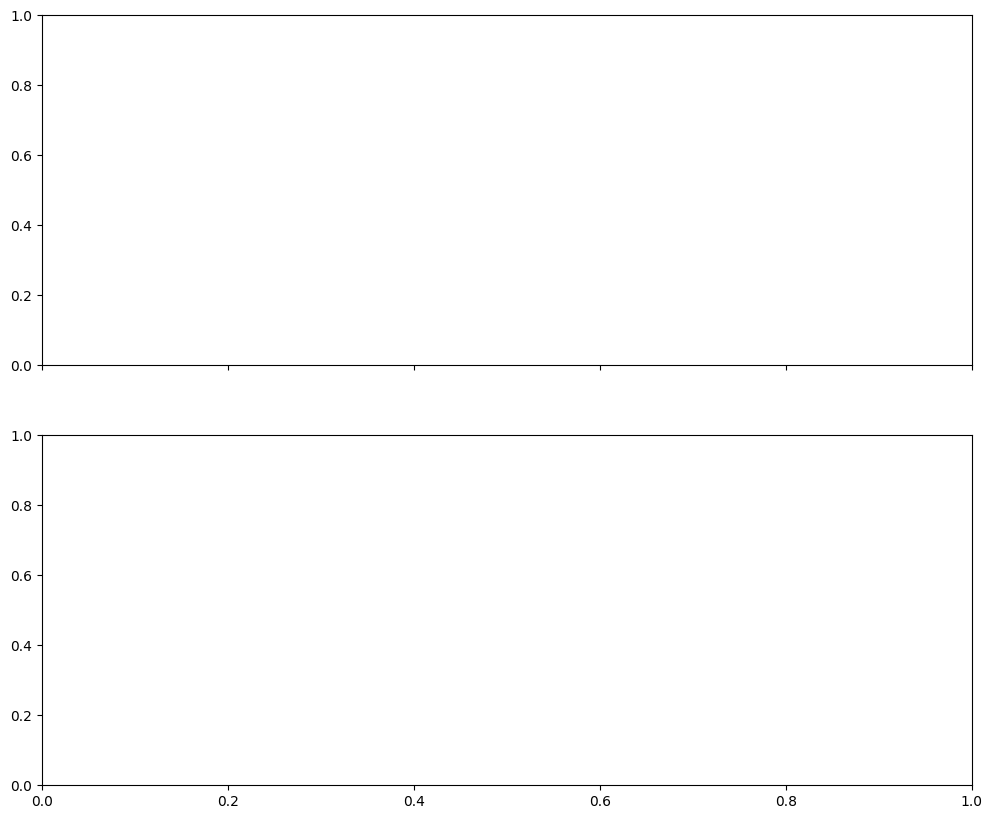

In [ ]:
# 9. Generate Dashboard
# We fetch history to show the trend
history_df = monitor_fg.read().sort_values(by='prediction_window_end')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Plot 1: Geomagnetic Activity Trend ---
# FIX: Plot ACTUAL Kp from history, and RED DOT for the prediction
# Filter last 48 hours of raw data for clarity
plot_df = solar_wind_df.tail(48)

ax1.plot(plot_df['date_and_time'], plot_df['kp_index'], color='black', linewidth=2, label='Observed Kp (Past)')
# Plot the forecast point
ax1.scatter([prediction_window_start], [predicted_kp], color='red', s=150, zorder=5, label='Next 3h Forecast')
# Add current threshold line based on the prediction
ax1.axhline(y=predicted_kp, color='red', linestyle='--', alpha=0.3)

ax1.set_ylabel('Kp Index', fontsize=12)
ax1.set_ylim(0, 9)
ax1.set_title('Global Geomagnetic Activity (Observed + Forecast)', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# --- Plot 2: City Visibility Signals ---
colors = {'Kiruna': 'forestgreen', 'Luleå': 'orange', 'Stockholm': 'purple'}

for i, city in enumerate(settings.CITIES.keys()):
    # Get history for this city
    city_hist = history_df[history_df['city'] == city].tail(24).copy()
    
    if not city_hist.empty:
        # Convert "GO" to 1, others to 0
        city_hist['go_val'] = city_hist['status'].apply(lambda x: 1 if x == "GO" else 0)
        
        # Plot steps (offset slightly so lines don't overlap perfectly)
        ax2.step(city_hist['prediction_window_start'], city_hist['go_val'] + (i * 0.05), 
                 label=f'{city}', color=colors[city], where='post', linewidth=2)

ax2.set_ylabel('Visibility Signal (1=GO)', fontsize=12)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['No', 'GO!'])
ax2.set_title('Actionable Visibility History', fontsize=14)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.2)

# Formatting
plt.xlabel('Time (UTC)', fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
fig.autofmt_xdate()

# Save locally
dashboard_path = "aurora_dashboard.png"
plt.savefig(dashboard_path, bbox_inches='tight')
print(f"\nDashboard saved locally to {dashboard_path}")
plt.show()

# Upload to Hopsworks (Optional)
dataset_api = project.get_dataset_api()
if not dataset_api.exists("Resources/aurora"):
    dataset_api.mkdir("Resources/aurora")

dataset_api.upload(dashboard_path, "Resources/aurora/latest_dashboard.png", overwrite=True)
print("Dashboard uploaded to Hopsworks Resources.")